In [105]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
def read_data(root_path: str = "./dataset/ETT-small/", 
              data_path: str = "ETTm2.csv",
              seq_len: int = 96,
              set_type: int = 2, # test
              features: str = 'S',
              target: str = 'OT',
              scale: bool = True,
              timeenc: int = 0,
              freq: int = None,
             ):
    scaler = StandardScaler()
    df_raw = pd.read_csv(os.path.join(root_path,
                                      data_path))
    # 24*4 is one day's data, 15min/per data,
    # 12 is one year
    border1s = [0,

                # (   34560  )
                # 1 year - seq_len
                12 * 30 * 24 * 4 - seq_len,

                # (             46080             )
                # 1 year + 4 month
                12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - seq_len]

    #           (     34560    )
    border2s = [12 * 30 * 24 * 4,

                # (             46080             )
                # 1 year + 4 month = 15 months
                12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,

                # 1 year + 8 month = 20 months
                12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]

    # for non stationary training
    # border1s = [0, 700 - seq_len, 850 - seq_len]
    # border2s = [700, 850, 995]
    #
    # #10 k non-stationary
    # border1s = [0, 9000 - seq_len, 9500 - seq_len]
    # border2s = [9000, 9500, 9990]

    # for val, 1
    # 1 year - seq_len
    border1 = border1s[set_type]

    # 1 year + 4 month = 15 months
    border2 = border2s[set_type]

    if features == 'M' or features == 'MS':
        cols_data = df_raw.columns[1:]  # no heading
        df_data = df_raw[cols_data]
    elif features == 'S':
        # for univariate, this is "OT"
        df_data = df_raw[[target]]
    if scale:
        train_data = df_data[border1s[0]:border2s[0]]
        scaler.fit(train_data.values)
        data = scaler.transform(df_data.values)
    else:
        data = df_data.values
    # for train: 1 years data
    # or val: 4 month after 1 year
    df_stamp = df_raw[['date']][border1:border2]
    df_stamp['date'] = pd.to_datetime(df_stamp.date)
    if timeenc == 0:
        df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
        df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
        df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
        df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
        df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
        df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
        data_stamp = df_stamp.drop(['date'], axis=1).values
    elif timeenc == 1:
        data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=freq)
        data_stamp = data_stamp.transpose(1, 0)

    data_x = data[border1:border2]
    data_y = data[border1:border2]
    data_stamp = data_stamp
    return data_x, data_y, data_stamp, scaler

In [106]:
data_x, data_y, data_stamp, scaler = read_data(set_type = 0)

/var/folders/3c/4336tt352pn6hnc003pk93080000gn/T/ipykernel_40353/1198422126.py:71: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.

/var/folders/3c/4336tt352pn6hnc003pk93080000gn/T/ipykernel_40353/1198422126.py:72: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.

/var/folders/3c/4336tt352pn6hnc003pk93080000gn/T/ipykernel_40353/1198422126.py:73: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.

/var/folders/3c/4336tt352pn6hnc003pk93080000gn/T/ipykernel_40353/1198422126.py:74: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).appl

In [107]:
data_x

array([[1.01803216],
       [0.98012448],
       [0.90422282],
       ...,
       [0.86622851],
       [0.86622851],
       [0.84727484]])

In [108]:
len(data_y)

34560

In [109]:
unscaled_y = scaler.inverse_transform(data_y)

In [110]:
unscaled_y[0:10]

array([[38.66199875],
       [38.22299957],
       [37.34400177],
       [37.12400055],
       [37.12400055],
       [36.90399933],
       [36.90399933],
       [36.46500015],
       [36.46500015],
       [36.46500015]])

In [112]:
def getitem(index: int,
            data_x,
            data_y,
            data_stamp,
            pred_len: int = 96,
            seq_len: int = 96,
            label_len: int = 96,):
    s_begin = index
    s_end = s_begin + seq_len
    r_begin = s_end - label_len
    r_end = r_begin + label_len + pred_len

    seq_x = data_x[s_begin:s_end] # length is seq_len
    seq_y = data_y[r_begin:r_end] # length = label_len + pred_len
    seq_x_mark = data_stamp[s_begin:s_end]
    seq_y_mark = data_stamp[r_begin:r_end]

    return seq_x, seq_y, seq_x_mark, seq_y_mark

In [170]:
seq_x, seq_y, seq_x_mark, seq_y_mark = getitem(index = 10, 
                                               data_x = data_x,
                                               data_y = data_y,
                                               data_stamp = data_stamp,
                                               pred_len = 96)

In [171]:
len(seq_y)

192

In [172]:
# seq_y = [[0] for i in seq_y]

In [173]:
seq_y[:5]

array([[0.77141601],
       [0.69551402],
       [0.58166154],
       [0.52471356],
       [0.48680555]])

In [174]:
seq_x[:10]

array([[0.77141601],
       [0.69551402],
       [0.58166154],
       [0.52471356],
       [0.48680555],
       [0.46780873],
       [0.42985773],
       [0.41090389],
       [0.39190674],
       [0.35399906]])

In [175]:
def predict(batch_x, 
             batch_y, 
             batch_x_mark, 
             batch_y_mark,
             model,
             device,
             pred_len: int = 96,
             label_len: int = 96,
             output_attention: bool = False,
             use_amp: bool = False,
             features: str = "S",
            ):
    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float() # mask
    dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
    # encoder - decoder

    def _run_model():
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        if output_attention:
            outputs = outputs[0]
        return outputs

    if use_amp:
        with torch.cuda.amp.autocast():
            outputs = _run_model()
    else:
        outputs = _run_model()

    f_dim = -1 if features == 'MS' else 0
    outputs = outputs[:, -pred_len:, f_dim:]
    batch_y = batch_y[:, -pred_len:, f_dim:].to(device)

    return outputs, batch_y

In [176]:
model_path = "checkpoints/ETTm2_96_96_Autoformer_ETTm2_ftS_sl96_ll96_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/checkpoint.pth"

In [177]:
from argparse import Namespace
configs = Namespace(
    is_training=1, 
    model_id='ETTm2_96_96', 
    model='Autoformer', 
    data='ETTm2', 
    root_path='./dataset/ETT-small/', 
    data_path='ETTm2.csv', 
    features='S', 
    target='OT', 
    freq='t', 
    checkpoints='./checkpoints/', 
    seq_len=96, 
    label_len=96, 
    pred_len=96, 
    bucket_size=4, 
    n_hashes=4, 
    enc_in=1, 
    dec_in=1, 
    c_out=1, 
    d_model=512, 
    n_heads=8, 
    e_layers=2, 
    d_layers=1, 
    d_ff=2048, 
    moving_avg=25, 
    factor=3, 
    distil=True, 
    dropout=0.05, 
    embed='timeF', 
    activation='gelu', 
    output_attention=False, 
    do_predict=False, 
    num_workers=10, 
    itr=1, 
    train_epochs=10, 
    batch_size=32, 
    patience=3, 
    learning_rate=0.0001, 
    des='Exp', 
    loss='mse', 
    lradj='type1', 
    use_amp=False, 
    use_gpu=True, 
    gpu=0, 
    use_multi_gpu=False, 
    devices='0,1,2,3'
)

In [178]:
from models import Autoformer

In [179]:
af = Autoformer.Model(configs)

In [180]:
import torch
af.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [181]:
# batch_x, batch_y, batch_x_mark, batch_y_mark = [seq_x], [seq_y], [seq_x_mark], [seq_y_mark]
def get_batch(raw_data):
    batched = torch.tensor(raw_data, dtype=torch.float32)
    batched = batched.unsqueeze(0)
    return batched

In [182]:
batch_x = get_batch(seq_x)
batch_y = get_batch(seq_y)
batch_x_mark = get_batch(seq_x_mark)
batch_y_mark = get_batch(seq_y_mark)

In [183]:
def tensor_2_df(start_date: str, batch_to_convert, scaler, col_name:str = "value", freq:str = '15min'):
    import pandas as pd
    squ_tensor = batch_to_convert.squeeze(0)
    np_tensor = squ_tensor.detach().numpy()
    unscaled_np_tensor = scaler.inverse_transform(np_tensor)
    df_tensor = pd.DataFrame(unscaled_np_tensor, columns=[col_name])
    date_range = pd.date_range(start=start_date, periods=len(df_tensor), freq='15min')
    df_tensor['date'] = date_range
    df_tensor = df_tensor[['date', col_name]]
    return df_tensor

In [184]:
revert_y = tensor_2_df(start_date = '2016-07-01 00:00:00', batch_to_convert = batch_y, scaler = scaler)

In [185]:
revert_y

,date,value
0,2016-07-01 00:00:00,35.806000
1,2016-07-01 00:15:00,34.926998
2,2016-07-01 00:30:00,33.608501
3,2016-07-01 00:45:00,32.949001
4,2016-07-01 01:00:00,32.509998
...,...,...
187,2016-07-02 22:45:00,28.554501
188,2016-07-02 23:00:00,28.554501
189,2016-07-02 23:15:00,28.554501
190,2016-07-02 23:30:00,28.554501


In [186]:
batch_x.shape

torch.Size([1, 96, 1])

In [187]:
batch_y.shape

torch.Size([1, 192, 1])

In [188]:
batch_x_mark.shape

torch.Size([1, 96, 5])

In [189]:
batch_y_mark.shape

torch.Size([1, 192, 5])

In [190]:
outputs, batch_y = predict(batch_x=batch_x, 
                           batch_y=batch_y, 
                           batch_x_mark=batch_x_mark, 
                           batch_y_mark=batch_y_mark, 
                           model=af, device=torch.device('cpu'))

In [191]:
o_processed = tensor_2_df(start_date = '2016-07-02 00:00:00', batch_to_convert = outputs, scaler = scaler)

In [192]:
batch_y[0][:5], outputs[0][:5]

(tensor([[-0.1014],
         [-0.1014],
         [-0.1014],
         [-0.1014],
         [-0.1014]]),
 tensor([[7.8331],
         [7.8475],
         [7.9507],
         [7.9378],
         [7.8444]], grad_fn=<SliceBackward0>))

In [193]:
o_processed

,date,value
0,2016-07-02 00:00:00,117.585785
1,2016-07-02 00:15:00,117.751999
2,2016-07-02 00:30:00,118.947395
3,2016-07-02 00:45:00,118.797867
4,2016-07-02 01:00:00,117.716278
...,...,...
91,2016-07-02 22:45:00,112.427795
92,2016-07-02 23:00:00,114.425339
93,2016-07-02 23:15:00,117.492439
94,2016-07-02 23:30:00,120.660240


In [194]:
outputs_seq = outputs.squeeze(0)

In [195]:
outputs_seq.shape

torch.Size([96, 1])

In [196]:
np_outputs_seq[:5]

array([[5.283537 ],
       [5.6442604],
       [5.805705 ],
       [5.9802313],
       [6.290456 ]], dtype=float32)

In [197]:
np_outputs_seq = outputs_seq.detach().numpy()

In [198]:
unscaled_output = scaler.inverse_transform(np_outputs_seq)

In [199]:
unscaled_output[:5]

array([[117.585785],
       [117.752   ],
       [118.947395],
       [118.79787 ],
       [117.71628 ]], dtype=float32)

In [200]:
import pandas as pd

In [201]:
df_data = pd.DataFrame(unscaled_output, columns=['predicted_result'])

In [202]:
df_data

,predicted_result
0,117.585785
1,117.751999
2,118.947395
3,118.797867
4,117.716278
...,...
91,112.427795
92,114.425339
93,117.492439
94,120.660240


In [203]:
start_date = '2016-07-02 00:00:00'
date_range = pd.date_range(start=start_date, periods=len(df_data), freq='15T')
df_data['date'] = date_range
df_data = df_data[['date', 'predicted_result']]

/var/folders/3c/4336tt352pn6hnc003pk93080000gn/T/ipykernel_40353/2614966839.py:2: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [204]:
df_data

,date,predicted_result
0,2016-07-02 00:00:00,117.585785
1,2016-07-02 00:15:00,117.751999
2,2016-07-02 00:30:00,118.947395
3,2016-07-02 00:45:00,118.797867
4,2016-07-02 01:00:00,117.716278
...,...,...
91,2016-07-02 22:45:00,112.427795
92,2016-07-02 23:00:00,114.425339
93,2016-07-02 23:15:00,117.492439
94,2016-07-02 23:30:00,120.660240


In [205]:
seq_x_, seq_y_, seq_x_mark_, seq_y_mark_ = getitem(index = 0, 
                                               data_x = data_x,
                                               data_y = data_y,
                                               data_stamp = data_stamp,
                                               pred_len = 96)

In [206]:
correct = scaler.inverse_transform(seq_y_)

In [207]:
correct[-9]

array([28.33499908])

In [208]:
start_date_correct = '2016-07-01 00:00:00'
correct_date_range = pd.date_range(start=start_date_correct, periods=len(correct), freq='15min')

In [209]:
correct_date_range[-1]

Timestamp('2016-07-02 23:45:00')

In [210]:
df_correct = pd.DataFrame(correct, columns=['correct'])

In [211]:
df_correct['date'] = correct_date_range

In [212]:
df_correct = df_correct[['date', 'correct']]

In [213]:
df_correct

,date,correct
0,2016-07-01 00:00:00,38.661999
1,2016-07-01 00:15:00,38.223000
2,2016-07-01 00:30:00,37.344002
3,2016-07-01 00:45:00,37.124001
4,2016-07-01 01:00:00,37.124001
...,...,...
187,2016-07-02 22:45:00,27.455999
188,2016-07-02 23:00:00,27.236500
189,2016-07-02 23:15:00,27.236500
190,2016-07-02 23:30:00,27.236500


In [214]:
import plotly.graph_objects as go

In [215]:
highlight_length = 5

In [216]:
fig = go.Figure(go.Scatter(x=df_correct['date'], y=df_correct['correct'], mode='lines', name='Correct Data'))

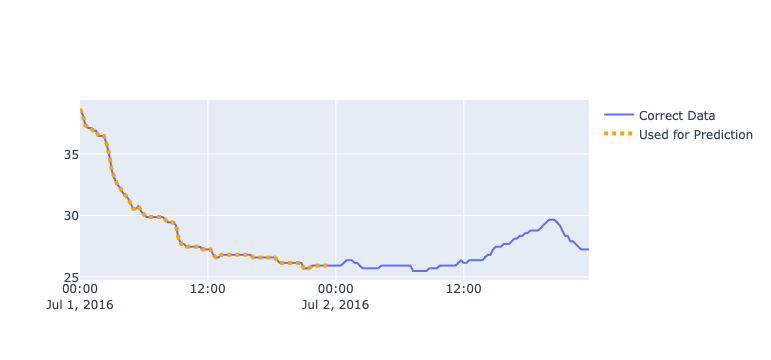

In [217]:
fig.add_trace(go.Scatter(x=df_correct['date'][:95], y=df_correct['correct'][:95],
                         mode='lines', name='Used for Prediction', line=dict(color='orange', width=4, dash='dot')))


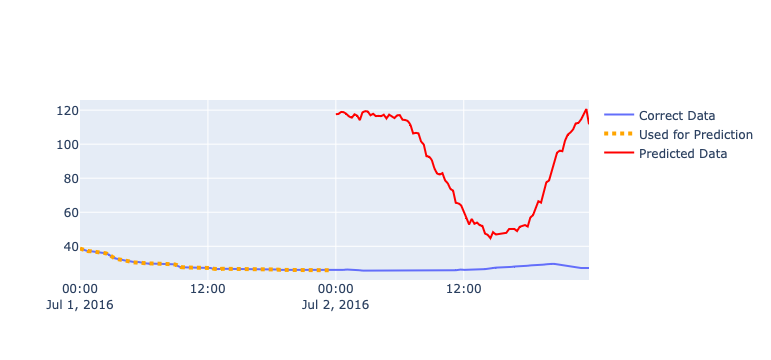

In [218]:
fig.add_trace(go.Scatter(x=df_data['date'], y=df_data['predicted_result'],
                         mode='lines', name='Predicted Data', line=dict(color='red')))

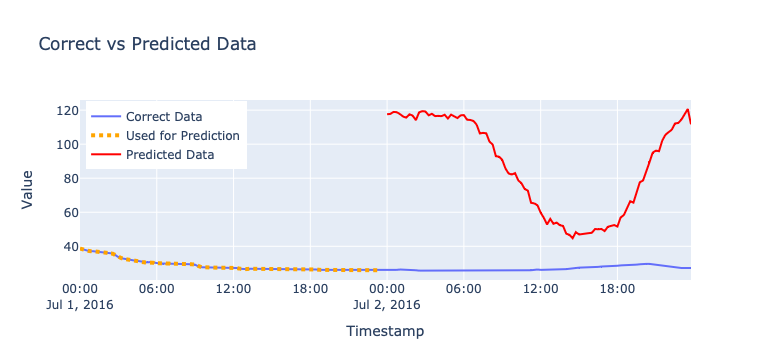

In [219]:
fig.update_layout(title='Correct vs Predicted Data',
                  xaxis_title='Timestamp',
                  yaxis_title='Value',
                  legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))

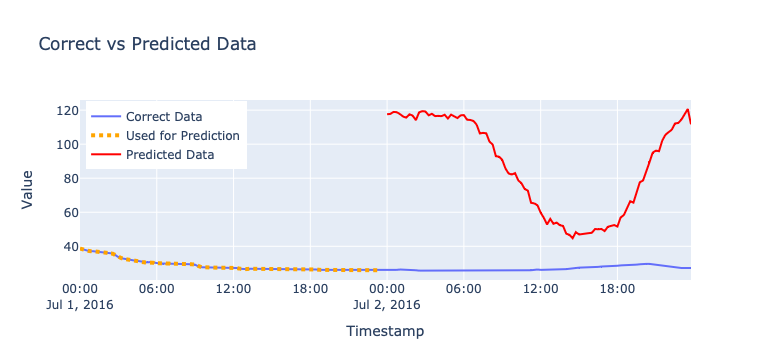

In [220]:
fig.show()